# Support Center Queue

Jill manages a software support center.  Jill wants to run an analysis on how long support requests remain in the system before getting resolved.  Collecting some stats and showing a Histogram of request time in system seems like a nice outcome.  Jill has data of when each request enters the system, and when each request is resolved.  

One methodology is to gather various Scenarios for which to analyze.  For example, a Busy Post Launch Scenario, a Mild Scenario,  A Monday Morning Scenario, etc.   And then use these scenarios to plan staffing, etc.

To test her methodology and code, she will use the following small dataset and make the following assumptions:

- Jobs arrive, are processed, and complete only at integral units of minutes
- Request arrival times:  `0, 5, 10, 12, 14, 15, 55`
- So, the time between arrivals is `5, 5, 2, 2, 1, 40`
- Service times for each request, that is, time to resolve once started: `4, 4, 10, 10, 10, 10, 1`
- There is a single support staff that processes requests First-In-First-Out (FIFO)

In [1]:
import simpy
import numpy as np
import functools
import matplotlib.pyplot as plt
from pprint import pprint

In [2]:
system_time = []
interarrival_times = [5, 5, 2, 2, 1, 40]
service_times = [4, 4, 10, 10, 10, 10, 1] 
NUM_JOBS = len(service_times)

In [3]:
def source(env, number, res):
    """ Generate arrivals into our simulation
    
    Arguments:   
     env:  Our simulation environment
     number: number of jobs to generate
     res: Shared resource
    """
    for i in range(number):     # keep looping until all jobs are generated
        service_time = service_times.pop(0)   # grab the first service time and then delete from list
        job_name = f'Job_{i}'      # create a job name string 
        print(f'\nGenerate {job_name} with service time: {service_time}')
        j = job(env, job_name, res, service_time)   # create a new job and add it to our simulation env
        env.process(j)
        
        if len(time_between_jobs) > 0:   # make sure there is another interarrival time
            time_between = time_between_jobs.pop(0)  # grab first interarrival time from list
            print(f'Next Job in: {time_between} time units')  
            yield env.timeout(time_between)  # pause here for interarrival time

In [4]:
# +------------------------------+        +------------------------------+
# |                              |        |                              |
# |       producer               |        |        consumer              |
# |                              +-------->                              |
# | - interarrival times         |        | - reads from store           |
# | - service times              |        | - processes jobs             |
# | - Puts jobs in store         |        | - Disposes of jobs           |
# |                              |        |                              |
# +------------------------------+        +------------------------------+

system_time2 = []

def consumer(env, entity):
    name, service_time, request = entity 
    print(f'{env.now}: {name} arrived')
    arr_time = env.now
    yield request
    print(f'{env.now}: {name} Accessed the server')
    yield env.timeout(service_time)
    resource.release(request)
    dispose(env, (name, arr_time))


def producer(env, store, resource):
    
    # these arrays could be more complex objects that are produced by the producer
    # they could contain attributes that the consumer factors in to processing
    # they should keep track of statistics like "total wait time".
    interarrival_times = [5, 5, 2, 2, 1, 40]
    service_times = [4, 4, 10, 10, 10, 10, 1] 
    for i, (interarrival_time, service_time) in enumerate(zip(interarrival_times, service_times)):
        yield env.timeout(interarrival_time)
        request = resource.request()
        env.process(consumer(env, (i, service_time, request)))

def dispose(env, entity):
    name, arr_time = entity
    print(f'{env.now}: {name} left service') 
    total_time = env.now - arr_time  
    print(f'{env.now}: {name} Total time in system: {total_time}\n')
    system_time2.append(total_time)
        
class MonitoredResource(simpy.Resource):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.data = []

    def request(self, *args, **kwargs):
        self.data.append((self._env.now, len(self.queue)))
        return super().request(*args, **kwargs)

    def release(self, *args, **kwargs):
        self.data.append((self._env.now, len(self.queue)))
        return super().release(*args, **kwargs)
        
env = simpy.Environment()
store = simpy.Store(env, capacity=float('Inf'))
resource = MonitoredResource(env, capacity=1)
prod = env.process(producer(env, store, resource))
env.run()
resource.data

5: 0 arrived
5: 0 Accessed the server
9: 0 left service
9: 0 Total time in system: 4

10: 1 arrived
10: 1 Accessed the server
12: 2 arrived
14: 1 left service
14: 1 Total time in system: 4

14: 3 arrived
14: 2 Accessed the server
15: 4 arrived
24: 2 left service
24: 2 Total time in system: 12

24: 3 Accessed the server
34: 3 left service
34: 3 Total time in system: 20

34: 4 Accessed the server
44: 4 left service
44: 4 Total time in system: 29

55: 5 arrived
55: 5 Accessed the server
65: 5 left service
65: 5 Total time in system: 10



[(5, 0),
 (9, 0),
 (10, 0),
 (12, 0),
 (14, 1),
 (14, 1),
 (15, 1),
 (24, 2),
 (34, 1),
 (44, 0),
 (55, 0),
 (65, 0)]

In [6]:
def job(env, name, server, time_in_bank):
    """Customer arrives, is served and leaves.
    
    Arguments:
        env: 
    """
    print(f'{env.now}: {name} arrived\n')
    arr_time = env.now
    
    request = server.request()  # request the server
    yield request               # wait for the server
    print(f'{env.now}: {name} Accessed the server')
    yield env.timeout(time_in_bank)  # server processes job
    server.release(request)      # you must free up the server
    print(f'{env.now}: {name} left service') 
    
    total_time = env.now - arr_time  
    print(f'{env.now}: {name} Total time in system: {total_time}') 
    system_time.append(total_time)


In [7]:
# Setup and start the simulation
print('Support Center 1\n')
env = simpy.Environment()

# Start processes and run
server_resource = MonitoredResource(env, capacity=1)
env.process(source(env, NUM_JOBS, server_resource))
env.run()

Support Center 1


Generate Job_0 with service time: 4
0: Job_0 arrived



NameError: name 'time_between_jobs' is not defined

In [88]:
print('The average system time is:',np.mean(system_time))
server_resource.data

The average system time is: 27.571428571428573


[(0, 0),
 (0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (4, 6),
 (8, 5),
 (18, 4),
 (28, 3),
 (38, 2),
 (48, 1),
 (49, 0)]

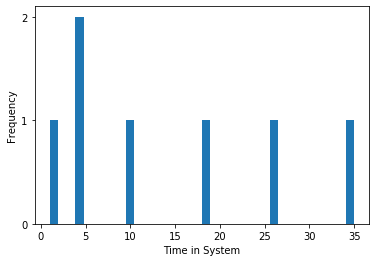

In [10]:
# Tinker with number of bins, until it looks right
plt.hist(system_time,bins=36)
# you can customize the exact tick marks on an axis
plt.yticks(range(0,3))
plt.ylabel('Frequency');
plt.xlabel('Time in System');

## The NumPy package provides lots of statistical methods, we call it with `np`

In [13]:
np.max(system_time)

35

In [14]:
# 50th percentile, or median
np.percentile(system_time,50)

10.0

In [15]:
np.median(system_time)

10.0

In [16]:
np.std(system_time)

11.868325191750639

# Support Center: Homework/Class work

Add to this notebook to answer the following:

1. Consider the number of jobs in the queue over time, from 0 until all jobs are completed
  - What is the average number of jobs in the queue?
  - Form a histogram of the number of jobs in the queue

1. Consider the time jobs spend in the queue, before beginning service.
  - What is the average time a job spends in the queue?
  - Form a histogram of the time jobs spend in the queue
  
